In [149]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [172]:
# Getting Stock quote
df = web.DataReader('BMW.DE', data_source='yahoo',start='2000-01-01', end='2022-01-01')
pd.set_option('display.max_columns', None)

# Get number of rows and columns
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,32.000000,28.660000,31.000000,29.490000,1335338.0,16.296951
2000-01-04,29.600000,27.730000,29.500000,28.299999,1564056.0,15.639324
2000-01-05,28.100000,27.000000,27.500000,27.740000,1359518.0,15.329853
2000-01-06,28.400000,27.000000,27.270000,27.650000,1064746.0,15.280117
2000-01-07,28.299999,27.270000,27.760000,27.600000,1575704.0,15.252487
...,...,...,...,...,...,...
2021-12-23,89.459999,87.980003,88.000000,89.169998,823550.0,89.169998
2021-12-27,90.110001,88.610001,88.720001,90.000000,396304.0,90.000000
2021-12-28,90.690002,89.750000,90.089996,89.949997,442096.0,89.949997


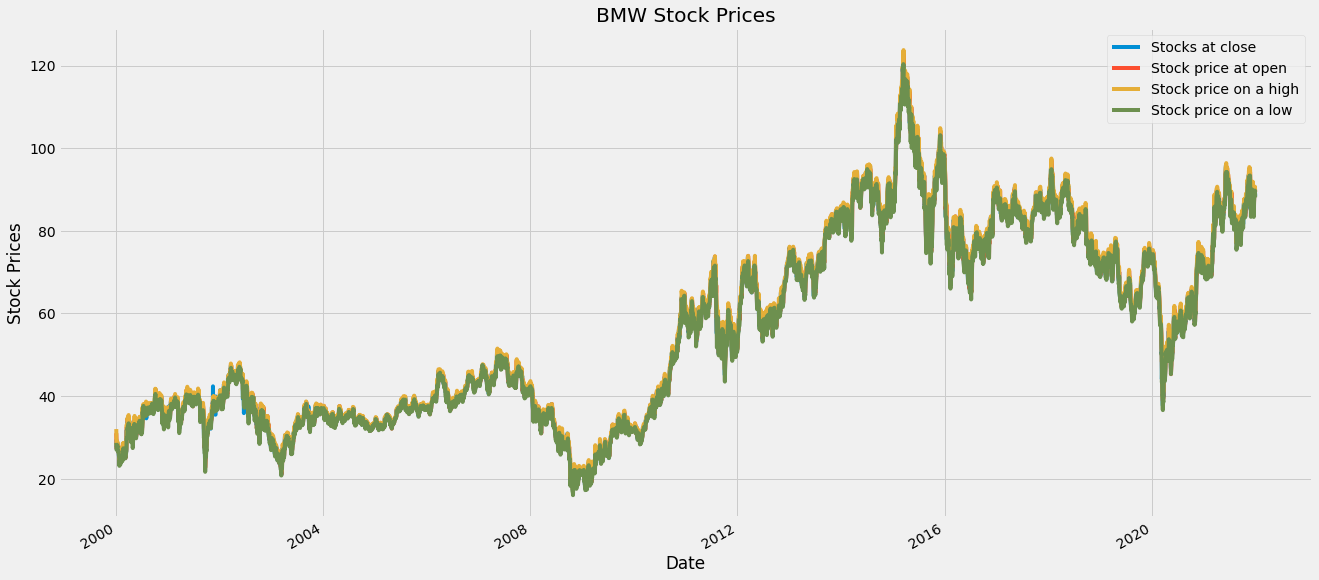

In [175]:
#Visualize some data
df['Close'].plot(label='Stocks at close', figsize=(20,10))
df['Open'].plot(label='Stock price at open')
df['High'].plot(label='Stock price on a high')
df['Low'].plot(label='Stock price on a low')
plt.legend()
plt.title('BMW Stock Prices')
plt.ylabel('Stock Prices')
plt.show()

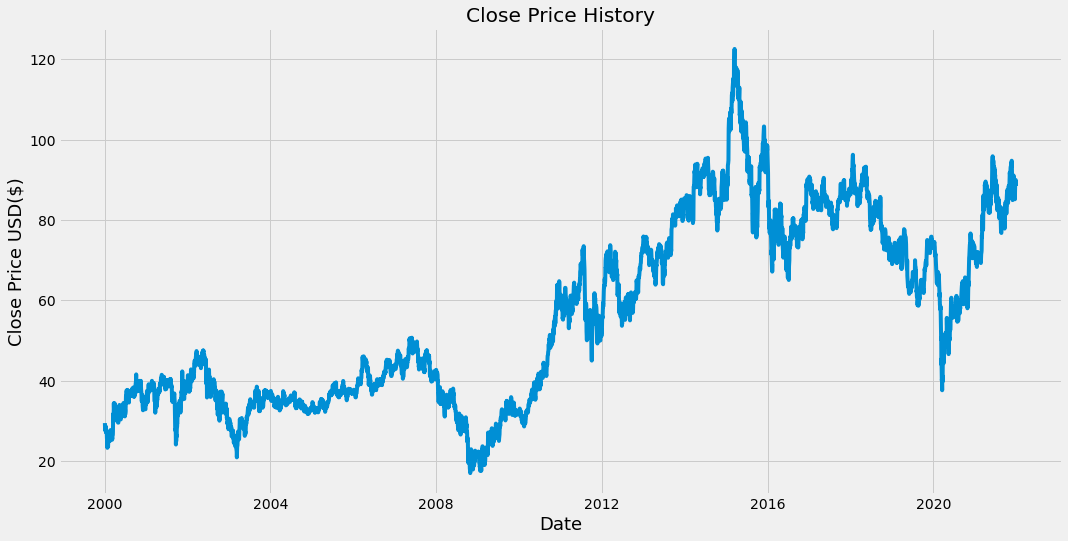

In [151]:
# Visualize some more data
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.show()

In [152]:
# Create New DataFrame with only close column
data = df.filter(['Close'])
#Convert the dataframe to a numpy array
dataset = data.values

In [153]:
# Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset) * .8)
print(training_data_len)

4500


In [176]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.11794239],
       [0.10666918],
       [0.10136414],
       ...,
       [0.69069721],
       [0.68359225],
       [0.67686622]])

In [155]:
# Create the training dataset
# Create a scaled training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    '''if i <=61:
        print(x_train)
        print(y_train)
        print()'''

In [156]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)

(4440, 60, 1)


In [157]:
# Build the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [158]:
#Compile the Model
model.compile(optimizer='adam',loss='mean_squared_error')

In [159]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

4440/4440 [==============================] - 84s 19ms/step - loss: 9.6218e-04


In [163]:
# Create the testing dataset
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60: , :]
#Create the datasets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [164]:
#Convert the data to numpy array
x_test = np.array(x_test)

In [165]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [166]:
#Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [167]:
#Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

1.7249846735190644

C:\Users\Viraj\AppData\Local\Temp\ipykernel_93484\2520009598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


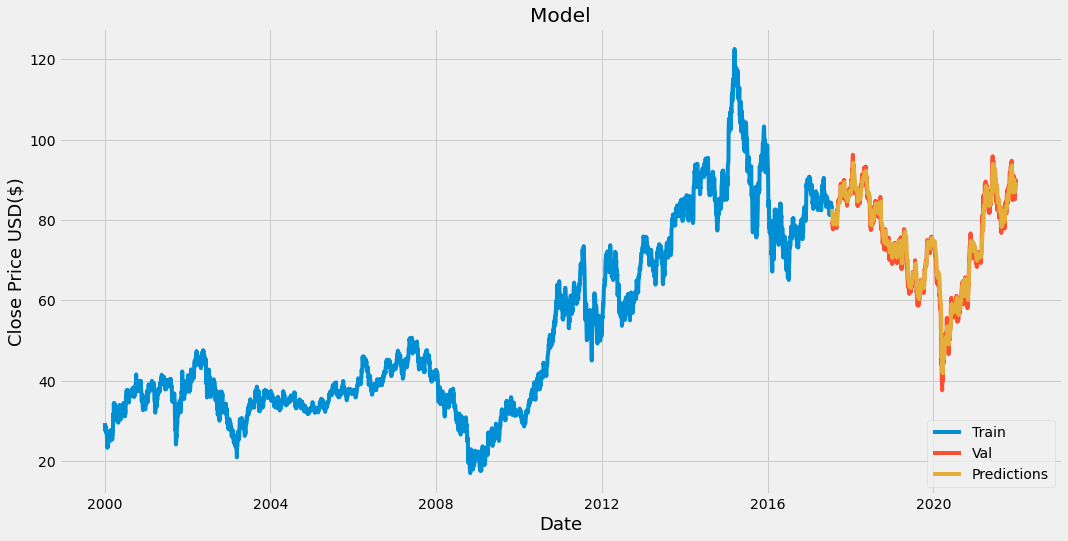

In [168]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [169]:
#Show the valid and predicted price
valid

,Close,Predictions
Date,,
2017-07-24,78.940002,82.803818
2017-07-25,79.430000,81.555428
2017-07-26,79.110001,80.719612
2017-07-27,78.500000,80.182396
2017-07-28,77.849998,79.740059
...,...,...
2021-12-23,89.169998,87.149124
2021-12-27,90.000000,87.890411
2021-12-28,89.949997,88.785652


In [170]:
# Get the quote
bmw_quote = web.DataReader('BMW.DE', data_source='yahoo', start='2000-01-01', end='2022-04-28')
# Create a new dataframe
new_df = bmw_quote.filter(['Close'])
#Get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create empty list
X_test = []
X_test.append(last_60_days_scaled)
#Convert the X_test dataset to numpy array
X_test = np.array(X_test)
#Reshape the data to be 3 dimensional
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[77.855545]]


In [171]:
# Get the quote
bmw_quote2 = web.DataReader('BMW.DE', data_source='yahoo', start='2022-04-29', end='2022-04-29')
print(bmw_quote2['Close'])

Date
2022-04-29    78.510002
Name: Close, dtype: float64
